# Apresentação

Inicio do estudo sobre o livro [Transformers: The Definitive Guide](https://www.oreilly.com/library/view/transformers-the-definitive/9781098167004/). O respectivo capítulo faz um apanhado geral dos principais topicos relacionados a **modelos de linguagem (_Large Language Models - LLMs)**, dando contextualização de do nascimento das ideias até como estas mesmas ideias são implementadas nos dias de hoje (Data de Lançamento do Livro: April 2026).

## Materiais de Consulta:
O livro possui um level de Intermediário para avançado, de modo que ele já pressupõe algum conhecimento prévio sobre algumas coisas. Deste modo, além do livro que será utilizado como texto base, também farei complementação do material de apoio formado por:
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- [Documentação da biblioteca transformers - Hugging face](https://huggingface.co/docs/transformers/index)
- [Álgebra Linear com Aplicações - Anton & Rorres](https://www.amazon.com.br/%C3%81lgebra-Linear-Aplica%C3%A7%C3%B5es-Howard-Anton/dp/8540701693)
- [Linear Algebra Done Right - Sheldon Axler](https://linear.axler.net/)
- [Github do Livro](https://github.com/Nicolepcx/transformers-the-definitive-guide)

In [1]:
import sys
import os
from pathlib import Path

# Encontra o diretório raiz do projeto (onde está a pasta 'utils')
notebook_dir = Path.cwd()
root_dir = notebook_dir.parent.parent  # Sobe dois níveis

# Adiciona ao sys.path
if str(root_dir) not in sys.path:
    sys.path.insert(0, str(root_dir))

In [2]:
from utils.utilities import get_image

# CUDA

Antes de nos aprofundarmos no conteúdo do livro, é importante entender um conceito essencial para computação acelerada: a tecnologia [**CUDA**](https://en.wikipedia.org/wiki/CUDA).

**CUDA** (sigla para *Compute Unified Device Architecture*) é uma **[plataforma de computação paralela e um modelo de programação desenvolvidos pela NVIDIA]((https://docs.nvidia.com/cuda/cuda-programming-guide/01-introduction/introduction.html))** que permite explorar o poder computacional das suas GPUs para além de gráficos. Originalmente concebida para renderização, a arquitetura das GPUs evoluiu para suportar **processamento general-purpose altamente paralelo**, o que é fundamental para aplicações intensivas em cálculo, como simulações científicas e aprendizado de máquina. 

Com CUDA, desenvolvedores podem escrever código que é executado diretamente na GPU, distribuindo milhares de **threads paralelas** por meio de APIs e ferramentas especialmente projetadas para acelerar cargas de trabalho que seriam lentas ou inviáveis num CPU convencional. Essa capacidade de paralelização é um dos pilares que tornou possível o treinamento e a inferência de modelos grandes de IA na prática.

No ecossistema de _deep learning_ moderno, bibliotecas como **PyTorch**, **TensorFlow** e outras dependem de CUDA para aproveitar aceleração por GPU de forma eficiente. Por isso, verificar se a máquina possui **compatibilidade** com CUDA e qual **versão** está disponível é uma etapa muito importante para realizar a instalação mais adequada de _frameworks_ à sua realidade.

## Alternativas ao CUDA para outras GPUs

Além de CUDA (NVIDIA), existem outras tecnologias para aceleração em diferentes hardwares:

* **[AMD ROCm](https://www.amd.com/pt/products/software/rocm.html):** pilha de computação aberta da AMD para GPUs Radeon/Instinct, com suporte a frameworks como PyTorch e TensorFlow em Linux.
* **[Intel XPU (PyTorch)](https://docs.pytorch.org/docs/stable/notes/get_start_xpu.html):** backend do PyTorch para GPUs Intel, ativado quando uma GPU Intel compatível está disponível. ([GitHub][2])
* **oneAPI / SYCL:** modelo de programação heterogênea aberto (via DPC++/SYCL) para CPUs/GPUs de múltiplos fabricantes. ([Intel](https://www.intel.com/content/www/us/en/developer/articles/technical/oneapi-a-viable-alternative-to-cuda-lock-in.html))
* **OpenCL / Vulkan Compute:** APIs abertas para computação paralela em GPUs de diferentes vendors (AMD, Intel, outros). ([TechGig](https://content.techgig.com/web-stories/best-parallel-computing-alternatives-to-cuda/web_stories/110740726.cms))
* **MPS (Apple) / DirectML (Windows):** aceleração específica de plataforma para GPUs Apple ou aceleração em Windows com múltiplas vendors (via DirectML). ([medium.com](https://medium.com/%40maxel333/running-ai-models-without-nvidia-and-cuda-a-modern-guide-to-open-alternatives-026d08c4e016))


In [ ]:
# Verificando compatibilidade e versão NVIDIA CUDA
! nvidia-smi

Sat Jan 31 13:53:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.44                 Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8             11W /  170W |    1196MiB /  12288MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Utilizei essas informações para baixar o **PyTorch** com a versão **CUDA** mas adequado ao meu contexto.

# Básico de Transformer

Aqui a autora trabalha as bases da **Arquitetura Transformer**. É uma contextualização dos pilares da arquitetura.

## Tokenizador: Representação de texto no Transformer

O tokenizador é utilizado para "tokenizar" o texto. Este é o primeiro passo para tornar a linguagem natural compreensível para o modelo, antes de aplicar os *token embeddings* (incorporações de tokens) e, finalmente, os *positional embeddings* (incorporações posicionais). Vamos avaliar de forma rápida, as principais formas de tokenização.

### Tokenização em nível de caractere

A tokenização em nível de caractere divide o alfabeto subjacente em cada caractere existente na sequência. Se você usasse esse método para a frase:

> "The Transformer has revolutionized NLP."

O resultado seria algo como:
`[T, h, e, ' ', … 'N, L, P, .]`

Isso gera sequências muito longas, o que pode aumentar a **complexidade computacional**. Também pode ser um desafio para o modelo aprender dependências de longo prazo. No entanto, pode ser útil se a sua tarefa exigir uma compreensão extremamente detalhada.

### Tokenização em nível de palavra

A tokenização em nível de palavra dividiria a frase de exemplo da seguinte forma:

`[The, Transformer, … NLP, .]`

Ou seja, a sequência será dividida em suas palavras, além da pontuação. A desvantagem é que isso exige um **vocabulário muito grande** e, se a língua mudar, essa tokenização não será capaz de entender novas palavras (o problema de palavras "fora do vocabulário").

### Tokenização de subpalavras (Subword)

A maioria dos LLMs (*Large Language Models*) modernos utiliza a tokenização de subpalavras, na qual a palavra é dividida em partes menores. Por exemplo, um tokenizador de subpalavras dividiria a palavra *hiking* em:

`[h, ik, ing]`

E a palavra *cooking* em:

`[cook, ing]`

Assim, a tokenização de subpalavras divide uma palavra (ou sequência) em pedaços menores que ocorrem com frequência, como o sufixo `[ing]`. Palavras de um único caractere também são incluídas.

## Embeddings de Token e Posicionais

Uma parte da arquitetura transformer que contém parâmetros treináveis são os _embeddings_ de token e _embeddings_ posicionais (PE). O _embedding_ de token tem a tarefa de codificar cada elemento do vocabulário em um vetor $d$-dimensional no espaço de $\mathbb{R}$ de $d_e$ ($\mathbb{R}^{d_e}$). O _embedding_ de token pode ser apresentado matematicamente da seguinte forma:

Seja $V$ o vocabulário com $|V| = N_v$, onde cada palavra $w$ em $V$ recebe um ID de token exclusivo, $v \in \{1, 2, \dots, N_v\}$. O _embedding_ de token é uma função $e: \mathbb{N} \to \mathbb{R}^{d_e}$ que mapeia cada ID de token para um vetor $d_e$-dimensional. Isso é alcançado por meio de uma matriz de _embedding_ de token $W_e \in \mathbb{R}^{d_e \times N_v}$, onde $d_e$ é a dimensionalidade dos _embeddings_. Veja como fazer isso usando [**Representações de Codificadores Bidirecionais de Transformers (BERT)**](https://arxiv.org/abs/1810.04805):

In [1]:
from transformers import AutoTokenizer, AutoModel

e:\book-based-learning\ZVenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import transformers
print(transformers.__version__)

5.0.0


In [2]:
# Instanciando tokenizer e modelos do Hugging Face:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

e:\book-based-learning\ZVenv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\amori\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading weights: 100%|██████████| 199/199 [00:00<00:00, 425.59it/s, Materializing param=pooler.dense.weight]               

In [8]:
# Texto de exemplo
sentence = "The Transformer has revolutionized NLP."

In [9]:
# Tokenizando o texto
inputs = tokenizer(sentence, return_tensors='pt');inputs

{'input_ids': tensor([[  101,  1996, 10938,  2121,  2038,  4329,  3550, 17953,  2361,  1012,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
# Obtendo IDs de entrada
input_ids = inputs['input_ids'];input_ids

tensor([[  101,  1996, 10938,  2121,  2038,  4329,  3550, 17953,  2361,  1012,
           102]])

In [ ]:
# Passando pelo modelo para obter os embeddings
outputs = model(input_ids);outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.5249, -0.2210,  0.2696,  ..., -0.4204,  0.2605,  0.6457],
         [-0.6665, -0.4994,  0.4651,  ..., -0.2517,  0.2334,  0.0176],
         [ 0.8416, -2.0561,  0.8323,  ..., -0.2709, -0.1999, -0.1918],
         ...,
         [-0.4018, -0.6402,  0.7791,  ..., -0.0290, -0.4070,  0.2974],
         [-0.3327, -0.8091, -0.0304,  ...,  0.4745,  0.3230, -0.5991],
         [ 0.4928, -0.0878, -0.0971,  ...,  0.1629, -0.7012, -0.3848]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.8649, -0.3196, -0.8335,  0.5834,  0.3777, -0.1860,  0.7201,  0.3197,
         -0.6697, -1.0000, -0.2142,  0.6403,  0.9547,  0.4311,  0.7592, -0.6474,
         -0.1426, -0.4597,  0.2820, -0.3289,  0.4869,  0.9999,  0.1542,  0.2198,
          0.3952,  0.8181, -0.5928,  0.8185,  0.9285,  0.6779, -0.5994,  0.2494,
         -0.9621, -0.0882, -0.8895, -0.9793,  0.4422, -0.6451,  0.1035, -0.0801,
         -0.7812,  0.3155,  0.99

In [13]:
# Obtendo o último estado oculto para acessar os embeddings dos tokens
embeddings = outputs.last_hidden_state
embeddings

tensor([[[-0.5249, -0.2210,  0.2696,  ..., -0.4204,  0.2605,  0.6457],
         [-0.6665, -0.4994,  0.4651,  ..., -0.2517,  0.2334,  0.0176],
         [ 0.8416, -2.0561,  0.8323,  ..., -0.2709, -0.1999, -0.1918],
         ...,
         [-0.4018, -0.6402,  0.7791,  ..., -0.0290, -0.4070,  0.2974],
         [-0.3327, -0.8091, -0.0304,  ...,  0.4745,  0.3230, -0.5991],
         [ 0.4928, -0.0878, -0.0971,  ...,  0.1629, -0.7012, -0.3848]]],
       grad_fn=<NativeLayerNormBackward0>)

Essa representação **não** inclui a posição da palavra na sequência. E como o **Transformer** não possui recorrência, ou seja, não precisa processar os dados sequencialmente como na representação original, você precisa de uma função para representar a posição. É por isso que você precisa adicionar **_embeddings_ posicionais (PE)**: sem eles, o modelo trata as sequências como coleções **não ordenadas** de palavras.

A função de **_embedding_ posicional** aprende a codificar a localização de um token dentro de uma sequência em um vetor no espaço $\mathbb{R}^{d_e}$. O Transformer original utiliza para a posição  $p_i$:

$$p_{i,2t} = \sin(k/10000^{2t/d})$$

$$p_{i,2t+1} = \cos(k/10000^{2t/d})$$

Aqui, $p_{i,2t}$ é o $2t$-ésimo elemento do vetor $d$-dimensional $p_i$. Isso significa que a posição do primeiro token é capturada por um vetor, $p[1]$, enquanto a posição do segundo token é capturada por um vetor aprendido diferente $p[2]$, e assim por diante.

Esta técnica permite que os modelos **Transformer** compreendam a **ordem das palavras**. Na próxima seção, veremos como o **Transformer** utiliza essa **representação vetorial** para entender e aprender com o texto.

    Esse embedding apresentado no artigo original é o que ficou conhecido como PE absoluto. Existe uma outra variação de PE conhecida como PE relativo. O livro deixa para explicar isso na parte da melhorias na arquitetura transformers. Eu entendo, mas eu acho que quera um pouco o fluxo, então vou explicar aqui.

### PE absoluto & PE Relativo

- Com PEs absolutos, para cada **_embedding_ de token**, o modelo adiciona informações sobre a posição absoluta do token. Os PEs absolutos são mais simples e rápidos de calcular.

- Os PEs relativos consideram distâncias entre elementos de sequência e podem ser compartilhados entre sequências, o que ajuda o modelo a entender e interpretar as relações e distâncias entre diferentes tokens dentro de uma sequência. As **PEs relativas** resultam em aumento de desempenho, mas são computacionalmente mais complexas.

## Mecanismo de Atenção (_Attention mechanism_)

O **mecanismo de atenção** é o coração da capacidade de entendimento e interpretabilidade de texto da **arquitetura Transformer**. Isso dá ao modelo a habilidade de analisar a relevância de uma palavra em uma sequência, token por token.

Nesse contexto, você ouvirá com frequência o termo matriz de atribuição (ou _attribution matrix_), que é calculada a partir dos _embeddings_ de entrada. Aqui, o termo atribuição (_attribution_) refere-se à importância (significância) entre diferentes partes da entrada.

    Ou seja, atribuição, porque você está atribuindo uma palavra a um contexto específico.

A matriz de atribuição é computada com as matrizes $Q$ (_query_ - consulta) e $K$ (_key_ - chave). Os scores resultantes formam a interação para determinar os pesos de atenção, que são então aplicados à matriz $V$ (_Value_ - valor) para produzir a saída do mecanismo de atenção:

$$Attention(Q,K,V)=Softmax(\frac{QK^T}{\sqrt{d_k}})V$$

Onde $Q$, $K$ e $V$ são computados via **projeções lineares** (um outro nome para **combinação linear**) dos _embeddings_ de entrada em matrizes de pesos.

    O livro não menciona, mas essa nomenclatura (Query, Key, Value) vem justamente do vocabulário de Banco de Dados. Aparentemente os autores do artigo se basearam nesse tipo de literatura para criar essa ideia.

- Query Matrix $Q$: $Q = W_q E$
- Key Matrix $K$:  $K = W_k E$
- Value Matrix $V$:  $V = W_v E$

Essa **matriz de atribuição** é crucial para entender como o modelo interpreta e processa as sequências de entrada correspondentes. Por exemplo, ao analisar essas pontuações, você pode obter insights sobre o processo de tomada de decisão do modelo, como quais tokens ele considera mais relevantes do que outros ao gerar o token de saída. 

Bibliotecas como o [Captum](https://captum.ai/) ajudam a tornar esse processo de tomada de decisão visível.

Nesta etapa, $E$ representa os _embeddings_ de entrada, e $W_q$, $W_k$ e $W_v$ são as matrizes de pesos para as projeções de _Query_ (consulta), _Key_ (chave) e _Value_ (valor), respectivamente.

1. Calcula-se o produto escalar das matrizes Query e Key.

2. Aplica-se a função softmax e o fator de escala (para a atenção de produto escalar escalonada).

3. O resultado será uma matriz de pontuações que representa a autoatenção (self-attention), ou quanto foco cada token deve colocar um no outro, considerando sua relação com todos os outros elementos da sequência.

Essas pontuações são então usadas para ponderar os valores na matriz $V$, produzindo a saída final de soma ponderada do mecanismo de atenção:

$$Output = AttentionScores \times V$$

    Apesar dessa notação, essa é um simples produto de matrizes (MatMul). Não é um produto vetorial.

Este processo dinâmico permite que o modelo foque em diferentes partes das sequências de entrada para cada token, tornando possível compreender a relevância contextual e a informação de cada um.


## Multi-head attention

O _Multi-head attention_ é uma espécie de _ensemble_ de vários mecânismos de atenção. Na prática, esse é o padrão. Não uma, mas sim múltiplas cabeças de atenção funcionando simultaneamente. Cada núcleo de atenção individual possui seus próprios parâmetros aprendíveis, que são então combinados em uma única saída. Isso permite um melhor desempenho do modelo.

Em termos técnicos, seja a sequencia $A$, $B$, $C, \dots$, o mecânismo de _multi-head attention_ computa novas representações para cada elemento em $A$ considerando informações de $B$, $C$ e assim por diante... Esse processo envolve várias etapas: cada cabeça calcula suas **próprias pontuações de atenção** e vetores de saída com base na entrada, depois **concatena** e **transforma linearmente** essas saídas para produzir o vetor de saída final $V$.
 

### atenção bidirecional e unidirecional

A **arquitetura Transformer** nasce como um modelo de tradução automática. É por isso que ele utiliza dois tipos distintos de **mecanismos de atenção** em sua arquitetura: um para o _encoder_ e outro para o _decoder_.

Primeiro, o _encoder_ aplica **autoatenção bidirecional**, e não apenas processamento da esquerda para a direita, como fazem os métodos tradicionais de processamento de sequências. Isso significa que ele trata **todos os tokens** como contexto, aplicando atenção **a cada token na sequência**. Isso proporciona ao modelo uma compreensão completa de toda a sequência de entrada ao gerar representações para **cada token**.

A atenção do _decoder_ é **mascarada** (também chamada de **atenção causal - _causal attention_**) para impedir que o modelo preste atenção a tokens futuros (posições subsequentes). Na prática, isso significa que, para a previsão, $i$ o modelo só pode prestar atenção à posição $< i$. Com esse método implementado, o modelo gera cada token com base **apenas nos tokens criados anteriormente**, da esquerda para a direita, impedindo-o, assim, de usar tokens futuros na sequência. Isso é importante para todas as tarefas em que o modelo deve gerar um token por vez, como, por exemplo, na tradução.

Agora que você entende as duas variações distintas de atenção usadas com o primeiro transformador, vamos analisar o _encoder_ e o _decoder_.

## Encoder e Decoder

A arquitetura do primeiro modelo Transformer foi caracterizada por sua estrutura de _encoder-decoder_. Alguns modelos subsequentes utilizam uma estrutura composta apenas por decodificadores, como **GPT**, **LLaMA**, **Mistral**e **Falcon**.

O _encoder_ em si é composto por $6$ **camadas idênticas**, cada uma contendo dois componentes principais: um **mecanismo de autoatenção multi-cabeças** e **uma rede neural feedforward totalmente conectada ponto a ponto**. O termo "ponto a ponto" refere-se à aplicação da mesma **transformação linear** a cada elemento da sequência. Esses componentes são refinados com **conexões residuais** e **camadas de normalização**.

O _decoder_ interpreta a informação codificada, espelhando a estrutura em camadas do _encoder_, mas introduzindo um recurso essencial: **autoatenção multi-cabeças mascarada**. Esse recurso adicional no _decodificador_ impede que o modelo acesse posições subsequentes na sequência.

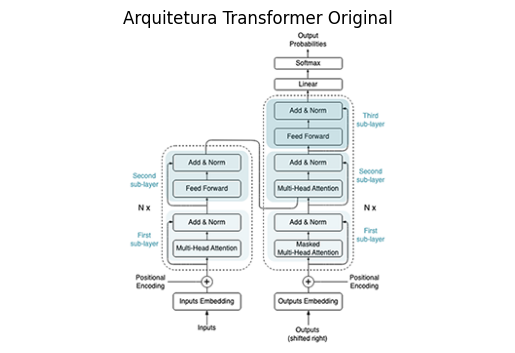

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098167004/files/assets/ttdg_0101.png",
    title="Arquitetura Transformer Original"
)

O modelo mantém uma dimensão de saída consistente de 512 em todas as subcamadas, incluindo as camadas de incorporação, o que significa que seu comprimento máximo de sequência é de 512 tokens. Essa limitação decorre principalmente da configuração arquitetônica específica do primeiro modelo Transformer, que dificultava o processamento eficiente de sequências mais longas no hardware disponível.

# Melhorias no designe da Arquitetura Transformers: Contextos mais longos e variações do mecanismo de atenção

Nessa segunda parte do capítulo, o autora trata de algumas melhorias no designe da arquitetura Transformers. Ela foca em dois pontos principais:

1. Melhorias na **Janela de Contexto**, permitindo o modelo precessar mais informação por prompt.

2. Variações no **mecanismo de atenção**.

## Janelas de Contexto maior e performance melhor

A **Janela de Contexto (_context window_)** refere-se ao número máximo de tokens que o modelo consegue considerar simultaneamente ao calcular a atenção e gerar uma predição. Quanto maior essa sequencia, maior a capacidade do modelo de entender narrativas complexas, dado que a informação é menos fragmentada.

A questão é que simplesmente aumentar a **janela de contexto** resulta em aumentos quadráticos na complexidade de tempo e no uso de memória, o que pode limitar melhorias. Para contornar esse problemas, o livro apresenta as seguintes abordagens:

- [_Rotary Positional Embedding_ (RoPE)](https://arxiv.org/abs/2104.09864)
- [_Positional Interpolation (PI)_](https://arxiv.org/abs/2306.15595) 
- [_Yet another RoPE ExtensioN method (YaRN)_](https://arxiv.org/abs/2309.00071)

### Rotary Positional _Embedding_ (RoPE)

O **RoPE** combina **PE** **absoluto** e **relativo** integrando uma **Matriz de Rotação** $R_{\Theta, m}$ para codificação absoluta da posição dos tokens, incorporando as dependências explicita das posições relativas no mecanismo de _self-attention_. 

Um exemplo de **Matriz de Rotação** de $d=6$

$$
R_{\Theta,m}^{6} =
\begin{bmatrix}
\cos(m\theta_1) & -\sin(m\theta_1) & 0 & 0 & 0 & 0 \\
\sin(m\theta_1) & \cos(m\theta_1)  & 0 & 0 & 0 & 0 \\
0 & 0 & \cos(m\theta_2) & -\sin(m\theta_2) & 0 & 0 \\
0 & 0 & \sin(m\theta_2) & \cos(m\theta_2)  & 0 & 0 \\
0 & 0 & 0 & 0 & \cos(m\theta_3) & -\sin(m\theta_3) \\
0 & 0 & 0 & 0 & \sin(m\theta_3) & \cos(m\theta_3)
\end{bmatrix}
$$

Dimensões superiores são divididas em $d/2$ subespaços, então o número de dimensão tem que ser par.

    Preciso dar uma olhada melhor na matemática por trás desses conceitos para entender melhor a técnica, o livro não explica muito sobre o background matemático.

Dito isso, fica mais fácil entender com código.

In [1]:
import torch

KeyboardInterrupt: 

In [5]:
def simple_rotary_matrix(d, m, max_len):

    # Verifica se a dimensão é par
    assert d % 2 == 0, "A dimensão dos embeddings deve ser par."

    # Computando os thetas para as frequências
    theta = 10000 ** (-1 * torch.arange(d//2).float()/d) 
    theta *= m

    # Computando o seno e consseno para a rotação
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)

    # Inicializando matriz de rotação
    R = torch.zeros((d,d))

    # Preenchendo matriz de rotação
    R[torch.arange(0, d, 2), torch.arange(0, d, 2)] = cos_theta
    R[torch.arange(0, d, 2), torch.arange(1, d, 2)] = -sin_theta
    R[torch.arange(1, d, 2), torch.arange(0, d, 2)] = sin_theta
    R[torch.arange(1, d, 2), torch.arange(1, d, 2)] = cos_theta

    return R

In [6]:
# Exemplo de uso
d = 6 # Dimensãõ dos embeddings
max_len = 10 # Comprimento máximo da sequência
R_matrix = simple_rotary_matrix(d, m=1, max_len=max_len)
print("Matriz de rotação (Rotary Positional Encoding):")
print(R_matrix)

Matriz de rotação (Rotary Positional Encoding):
tensor([[ 0.5403, -0.8415,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.5403,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.9769, -0.2138,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.2138,  0.9769,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.9989, -0.0464],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0464,  0.9989]])


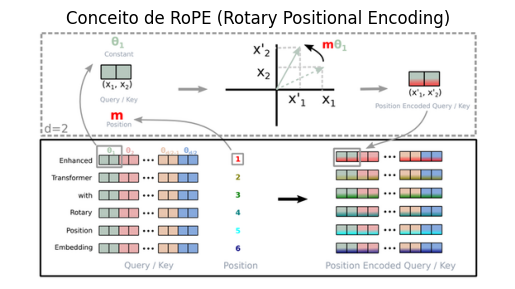

In [8]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098167004/files/assets/ttdg_0102.png",
    title="Conceito de RoPE (Rotary Positional Encoding)"
)

Para aplicar o RoPE no contexto do _self-attention_, defina a relação entre $q_m$ na posição $m$ e chave $k_n$ na posição $n$ como:

$$q_m^Tk_n = (R_{\Theta,m}^dW_{q}x_m)^T(R_{\Theta,m}^dW_kx_n)=x^TW_qR_{\Theta,m}^dW_kx_n$$

Onde $R_{\Theta,m-n}^d=(R_{\Theta,n}^d)$ representa a **matriz de rotação** adaptando a **posição relativa**.

Os proximos métodos são métodos para **expandir** a janela de contexto de **modelos fundacionais**. Ou seja, são formas de expandir a janela de contexto de modelos já treinados e funcionais. Mas antes vamos passar pela **Perplexidade** até cair nos outros métodos.

    A autora explica o que é perplexidade dentro de tópico Positional Interpolation (PI), mas eu acho confuso essas quebrar, então, por questão de organização e de relevância da Perplexidade, eu prefiro transforma-la num tópico a parte e anterior ao PI.

## Perplexidade

A **Perplexidade** é uma medida de quão "_surpreso_" ou "_perplexo_" o modelo está em relação ao contexto. Ou seja, a plerplexidade mede o quão bem um modelo de probabilidades prevê uma amostra, de modo que quanto menor a perplexidade, melhor a precisão preditiva.

In [ ]:
# Depedências utilizadas
from transformers import AutoModelForCausalLM, AutoTokenizer

e:\GithubProjects\book-based-learning\ZVenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Verificando compatibilidade e versão NVIDIA CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [ ]:
# Instanciando modelo
model = AutoModelForCausalLM.from_pretrained(
    "tiiuae/falcon-7b",
    device_map="auto",               # gerencia CPU/GPU
    dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
)

# Instanciando tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2") # Tokenizador diferente do usado no livro

`torch_dtype` is deprecated! Use `dtype` instead!
Loading weights: 100%|██████████| 196/196 [00:16<00:00, 12.14it/s, Materializing param=transformer.word_embeddings.weight]                    
The tied weights mapping and config for this model specifies to tie transformer.word_embeddings.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Some parameters are on the meta device because they were offloaded to the cpu and disk.


In [5]:
# Texto de exemplo
wiki_text = tokenizer("Apple Inc. is an American multinational " +
                      "corporation and technology company headquartered " +
                      "in Cupertino, California, in Silicon Valley. ",
                      return_tensors = "pt")

In [6]:
# Calculado perdas
loss = model(input_ids = wiki_text["input_ids"],
             labels = wiki_text["input_ids"]).loss

# Calculando perplexidade
ppl = torch.exp(loss)
print(ppl) # print

tensor(126976.2969, grad_fn=<ExpBackward0>)


In [7]:
# Outro exemplo
input_text = tokenizer("A Falcon is a generative transformer "+
                       "model and it can't fly.", return_tensors = "pt")

# Calculando perdas do segundo exemplo
loss = model(input_ids = input_text["input_ids"],
             labels = input_text["input_ids"]).loss

# Calculando perplexidade
ppl = torch.exp(loss)
print(ppl)


tensor(54047.9492, grad_fn=<ExpBackward0>)


## Positional Interpolation (PI)

Para estender a janela de contexto, o PI interpola os índices de posição dentro do limite pré-treinado, aplicando um pequeno conjunto de ajustes finos.

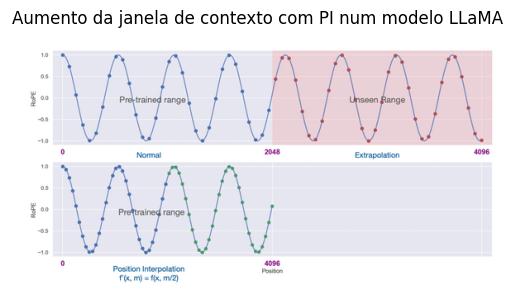

In [ ]:
get_image(
    "https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781098167004/files/assets/ttdg_0103.png",
    title="Aumento da janela de contexto com PI num modelo  LLaMA"
)

Os quadrados vermelhos ilustram como os modelos se adaptam a novas posições. Os pontos azuis e os triângulos verdes demonstram como o **PI** escala de [0, 4096] para [0, 2048] para mantê-los dentro da faixa treinada.

Ou seja, o **PI** estende a função **RoPE** $f$ po $f'$ da seguinte forma:

$$f'(x,m) = f(x, \frac{mL}{L'})$$

Aqui $L' > L$ é uma nova janela de contexto além da pré-treinada.

## Variações do Mecanismo de Atenção